**Importing Libraries and Aquiring Data**

In [ ]:
# iImporting libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import keras
import sklearn
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# importing Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the data
train = pd.read_csv('Price_Train.csv', date_parser=True)
test = pd.read_csv('Price_Test.csv', date_parser=True)

In [ ]:
train.head()

,Date,Open,High,Low,Close,Volume
0,16-11-09,160.0,195.0,160.0,177.3,7430400
1,17-11-09,176.1,186.0,170.1,171.1,2832800
2,18-11-09,170.1,170.2,158.0,158.2,2732000
3,19-11-09,158.1,167.9,152.0,164.0,1627200
4,22-11-09,167.0,168.9,163.0,165.7,872400


In [ ]:
# taking 'Open' price from data in 2D array
train_open = train.iloc[:, 1:2].values

In [ ]:
# scaling the values between 0 to 1

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_open)

In [ ]:
# declearing durations

train_scaled_duration = 90
needed_prediction_day = 30

**Training Window Length or, Train Scaled Duration**

Below we will be taking previous 90 days datasteps to predict the next values.
i.e for taking 0 to 89 days open price to get 90th day price as output, 1 to 90 for 91, 2 to 91 for 92

We chose 90, because, in 90 days, a season can change and thus, industrial production may vary accordingly.

In [ ]:
# feature selection

x_train = []
y_train = []

for i in range(train_scaled_duration + needed_prediction_day, len(train_scaled)):
    x_train.append(train_scaled[i - train_scaled_duration - needed_prediction_day: i - needed_prediction_day, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.array(x_train)

In [ ]:
# reshaping train data for LTSM layer input_shape(batchzise, timesteps, input_dim)
x_train = np.reshape(x_train, (-1, train_scaled_duration, 1))

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1848, 90, 1)
(1848,)


**The LSTM Network**

In [ ]:
# initialisizng LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=128, return_sequences=True, input_shape=(train_scaled_duration, 1)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=256, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=256, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=256, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=256))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1))

# compiling the network
model_lstm.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics='kullback_leibler_divergence')

# fitting the network
model_lstm.fit(x_train, y_train, batch_size=30, epochs=128)

Epoch 1/200
62/62 [==============================] - 56s 686ms/step - loss: 0.0077 - kullback_leibler_divergence: 0.0579
Epoch 2/200
62/62 [==============================] - 42s 682ms/step - loss: 0.0016 - kullback_leibler_divergence: 0.0085
Epoch 3/200
62/62 [==============================] - 42s 681ms/step - loss: 0.0016 - kullback_leibler_divergence: 0.0100
Epoch 4/200
62/62 [==============================] - 43s 688ms/step - loss: 0.0015 - kullback_leibler_divergence: 0.0074
Epoch 5/200
62/62 [==============================] - 42s 681ms/step - loss: 0.0015 - kullback_leibler_divergence: 0.0085
Epoch 6/200
62/62 [==============================] - 43s 694ms/step - loss: 0.0012 - kullback_leibler_divergence: 0.0063
Epoch 7/200
62/62 [==============================] - 43s 687ms/step - loss: 0.0012 - kullback_leibler_divergence: 0.0067
Epoch 8/200
62/62 [==============================] - 42s 681ms/step - loss: 0.0012 - kullback_leibler_divergence: 0.0059
Epoch 9/200
62/62 [=============

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 100)           60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 100)           8

################################################################################

**The CNN Network**

In [ ]:
# initialisizng CNN model
model_cnn = models.Sequential()

model_cnn.add(layers.Conv1D(filters=256, kernel_size=23, activation='relu', input_shape=(train_scaled_duration, 1)))
model_cnn.add(layers.MaxPooling1D(1))

model_cnn.add(layers.Conv1D(filters=512, kernel_size=23, activation='relu'))
model_cnn.add(layers.MaxPooling1D(1))

model_cnn.add(layers.Conv1D(filters=512, kernel_size=23, activation='relu'))
model_cnn.add(layers.MaxPooling1D(1))

model_cnn.add(layers.Conv1D(filters=512, kernel_size=23, activation='relu'))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(units=512, activation='relu'))

model_cnn.add(Dense(units=1))

# compiling the network
model_cnn.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics='kullback_leibler_divergence')

# fitting the network
model_cnn.fit(x_train, y_train, batch_size=30, epochs=128)

Epoch 1/200
62/62 [==============================] - 9s 133ms/step - loss: 0.0078 - kullback_leibler_divergence: 0.0487
Epoch 2/200
62/62 [==============================] - 8s 133ms/step - loss: 0.0017 - kullback_leibler_divergence: 0.0083
Epoch 3/200
62/62 [==============================] - 8s 133ms/step - loss: 0.0012 - kullback_leibler_divergence: 0.0052
Epoch 4/200
62/62 [==============================] - 8s 133ms/step - loss: 7.5990e-04 - kullback_leibler_divergence: 0.0036
Epoch 5/200
62/62 [==============================] - 8s 133ms/step - loss: 5.9271e-04 - kullback_leibler_divergence: 0.0026
Epoch 6/200
62/62 [==============================] - 8s 133ms/step - loss: 6.3563e-04 - kullback_leibler_divergence: 0.0038
Epoch 7/200
62/62 [==============================] - 8s 134ms/step - loss: 5.0392e-04 - kullback_leibler_divergence: 0.0015
Epoch 8/200
62/62 [==============================] - 8s 134ms/step - loss: 4.5552e-04 - kullback_leibler_divergence: 0.0022
Epoch 9/200
62/62 [=

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 80, 64)            768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 80, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 128)           90240     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           180352    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 60, 128)          0

**Test data**

As we have 'train_scaled_duration' input in our layer, we will concatenate our train and test and will take last 'train_scaled_duration' values of our training set with test set

In [ ]:
test_open = test.iloc[:, 1:2].values                                          # taking  open price
total = pd.concat([train['Open'], test['Open']], axis=0)                      # Concating train and test and then will take last 'train_scaled_duration' train point
test_input = total[len(total) - len(test) - train_scaled_duration : ].values
test_input = test_input.reshape(-1,1)                                         # reshaping it to get it transformed
test_input = scaler.transform(test_input)

################################################################################

In [ ]:
x_test = []
y_test = []

for i in range(train_scaled_duration + needed_prediction_day, len(test_input)):
    x_test.append(test_input[i - train_scaled_duration - needed_prediction_day: i - needed_prediction_day, 0] )            # creating input for cnn prediction
    y_test.append(test_input[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [ ]:
x_test = np.array(x_test)

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
print(x_test.shape)
print(y_test.shape)

(239, 90, 1)
(239,)


**Data Prediction**

In [ ]:
# predicting next values from LSTM model

predicted_value_lstm = model_lstm.predict(x_test)
predicted_value_lstm = scaler.inverse_transform(predicted_value_lstm)

In [ ]:
# predicting next values from CNN model

predicted_value_cnn = model_cnn.predict(x_test)
predicted_value_cnn = scaler.inverse_transform(predicted_value_cnn)

In [ ]:
print("LSTM Prediction Elements Size : ", predicted_value_lstm.size)
print("CNN Prediction Elements Size : ", predicted_value_cnn.size)

LSTM Prediction Elements Size :  239
CNN Prediction Elements Size :  239


################################################################################

In [ ]:
# calculating average value of LSTM and CNN array data
average_prediction = ( (predicted_value_lstm + predicted_value_cnn) / 2 )

In [ ]:
# Generating Randomness of Data

random_average_prediction = []
percent_shift_average = 0.25

for i in range(predicted_value_cnn.size):
  difference_lstm_cnn = abs(predicted_value_lstm[i] - predicted_value_cnn[i])
  n = random.randint(0,9)
  if(n >= 2 and n <= 7):
    x = np.random.uniform(average_prediction[i] - (difference_lstm_cnn * percent_shift_average), average_prediction[i] + (difference_lstm_cnn * percent_shift_average))
    random_average_prediction.append(x)
  elif (n >= 0 and n <= 1):
    x = np.random.uniform(predicted_value_lstm[i] - (difference_lstm_cnn * percent_shift_average), predicted_value_lstm[i] + (difference_lstm_cnn * percent_shift_average))
    random_average_prediction.append(x)
  elif (n >= 8 and n <= 9):
    x = np.random.uniform(predicted_value_cnn[i] - (difference_lstm_cnn * percent_shift_average), predicted_value_cnn[i] + (difference_lstm_cnn * percent_shift_average))
    random_average_prediction.append(x)

In [ ]:
print("Average Prediction Size : ", len(average_prediction))
print("Random Average Prediction Size : ", len(random_average_prediction))

Average Prediction Size :  239
Random Average Prediction Size :  239


In [ ]:
print("Total Real Price Size : ", len(test_open))

Total Real Price Size :  239


**Evaluating Models**

In [ ]:
# Calculating 'R squared' of Real Value & Predicted Value

print("R-2 of Random Average Prediction from Real Price : ", (metrics.r2_score(test_open, random_average_prediction)))
print("R-2 of LSTM Prediction from Real Price : ", (metrics.r2_score(test_open, predicted_value_lstm)))
print("R-2 of CNN Prediction from Real Price : ", (metrics.r2_score(test_open, predicted_value_cnn)))
print("R-2 of Average Prediction from Real Price : ", (metrics.r2_score(test_open, average_prediction)))

R-2 of Random Average Prediction from Real Price :  0.9769564809816623
R-2 of LSTM Prediction from Real Price :  0.959224822356698
R-2 of CNN Prediction from Real Price :  0.9872372099563974
R-2 of Average Prediction from Real Price :  0.9825889408174943


In [ ]:
# Calculating 'Mean Absolute Error' of Real Value & Predicted Value

print("Mean Absolute Error of Random Average Prediction from Real Price : ", (metrics.mean_absolute_error(test_open, random_average_prediction)))
print("Mean Absolute Error of LSTM Prediction from Real Price : ", (metrics.mean_absolute_error(test_open, predicted_value_lstm)))
print("Mean Absolute Error of CNN Prediction from Real Price : ", (metrics.mean_absolute_error(test_open, predicted_value_cnn)))
print("Mean Absolute Error of Average Prediction from Real Price : ", (metrics.mean_absolute_error(test_open, average_prediction)))

Mean Absolute Error of Random Average Prediction from Real Price :  5.906362482660064
Mean Absolute Error of LSTM Prediction from Real Price :  8.295443917118854
Mean Absolute Error of CNN Prediction from Real Price :  4.689700764292951
Mean Absolute Error of Average Prediction from Real Price :  5.255028888271442


In [ ]:
# Calculating 'Mean Square Error' of Real Value & Predicted Value

print("Mean Square Error of Random Average Prediction from Real Price : ", (metrics.mean_squared_error(test_open, random_average_prediction)))
print("Mean Square Error of LSTM Prediction from Real Price : ", (metrics.mean_squared_error(test_open, predicted_value_lstm)))
print("Mean Square Error of CNN Prediction from Real Price : ", (metrics.mean_squared_error(test_open, predicted_value_cnn)))
print("Mean Square Error of Average Prediction from Real Price : ", (metrics.mean_squared_error(test_open, average_prediction)))

Mean Square Error of Random Average Prediction from Real Price :  64.47513980525231
Mean Square Error of LSTM Prediction from Real Price :  114.08783862585365
Mean Square Error of CNN Prediction from Real Price :  35.7099396021728
Mean Square Error of Average Prediction from Real Price :  48.71567029568035


In [ ]:
# Calculating 'Root Mean Square Error' of Real Value & Predicted Value

print("Root Mean Square Error of Random Average Prediction from Real Price : ", np.sqrt(metrics.mean_squared_error(test_open, random_average_prediction)))
print("Root Mean Square Error of LSTM Prediction from Real Price : ", np.sqrt(metrics.mean_squared_error(test_open, predicted_value_lstm)))
print("Root Mean Square Error of CNN Prediction from Real Price : ", np.sqrt(metrics.mean_squared_error(test_open, predicted_value_cnn)))
print("Root Mean Square Error of Average Prediction from Real Price : ", np.sqrt(metrics.mean_squared_error(test_open, average_prediction)))

Root Mean Square Error of Random Average Prediction from Real Price :  8.029641324819703
Root Mean Square Error of LSTM Prediction from Real Price :  10.681190880508298
Root Mean Square Error of CNN Prediction from Real Price :  5.975779413781336
Root Mean Square Error of Average Prediction from Real Price :  6.979661187742593


In [ ]:
# Calculating 'Standard Error of the Estimate' of Real Value & Predicted Value

'''
s_estimate = sqrt{ sum( square( original_price - predicted_price ) ) / N-2 }

The denominator is N-2 rather than N.
Because N-2 is used rather than N-1 is that two parameters 'slope' and 'intercept' were estimated in order to estimate the sum of squares.
'''

sest_rand = np.sqrt(np.sum(abs(np.square(test_open - random_average_prediction))) / (len(test_open) - 2))
print("Standard Error of the Estimate of Random Average Prediction from Real Price : ", sest_rand)

sest_lstm = np.sqrt(np.sum(abs(np.square(test_open - predicted_value_lstm))) / (len(test_open) - 2))
print("Standard Error of the Estimate of LSTM Prediction from Real Price : ", sest_lstm)

sest_cnn = np.sqrt(np.sum(abs(np.square(test_open - predicted_value_cnn))) / (len(test_open) - 2))
print("Standard Error of the Estimate of CNN Prediction from Real Price : ", sest_cnn)

sest_avg = np.sqrt(np.sum(abs(np.square(test_open - average_prediction))) / (len(test_open) - 2))
print("Standard Error of the Estimate of Average Prediction from Real Price : ", sest_avg)

Standard Error of the Estimate of Random Average Prediction from Real Price :  8.06345049045678
Standard Error of the Estimate of LSTM Prediction from Real Price :  10.726164514705896
Standard Error of the Estimate of CNN Prediction from Real Price :  6.000940701544797
Standard Error of the Estimate of Average Prediction from Real Price :  7.009049364828121


In [ ]:
# Calculating 'Average Dispersion' of Real Value & Predicted Value

avd_rand = np.mean(abs(test_open - random_average_prediction))
print("Average Dispersion of Random Average Prediction from Real Price's distance : ", avd_rand)

avd_lstm = np.mean(abs(test_open - predicted_value_lstm))
print("Average Dispersion of LSTM Prediction from Real Price's distance : ", avd_lstm)

avd_cnn = np.mean(abs(test_open - predicted_value_cnn))
print("Average Dispersion of CNN Prediction from Real Price's distance : ", avd_cnn)

avd_avg = np.mean(abs(test_open - average_prediction))
print("Average Dispersion of Average Prediction from Real Price's distance : ", avd_avg)

Average Dispersion of Random Average Prediction from Real Price's distance :  5.906362482660064
Average Dispersion of LSTM Prediction from Real Price's distance :  8.295443917118854
Average Dispersion of CNN Prediction from Real Price's distance :  4.689700764292951
Average Dispersion of Average Prediction from Real Price's distance :  5.255028888271442


In [ ]:
# Calculating 'Satandard Deviation' of 'Average Dispersion' of Real Value & Predicted Value

std_rand = np.std(abs(test_open - random_average_prediction))
print("Standard Deviation of Average Dispersion of Random Average Prediction from Real Price's distance : ", std_rand)

std_lstm = np.std(abs(test_open - predicted_value_lstm))
print("Standard Deviation of Average Dispersion of LSTM Prediction from Real Price's distance : ", std_lstm)

std_cnn = np.std(abs(test_open - predicted_value_cnn))
print("Standard Deviation of Average Dispersion of CNN Prediction from Real Price's distance : ", std_cnn)

std_avg = np.std(abs(test_open - average_prediction))
print("Standard Deviation of Average Dispersion of Average Prediction from Real Price's distance : ", std_avg)

Standard Deviation of Average Dispersion of Random Average Prediction from Real Price's distance :  5.439671132401109
Standard Deviation of Average Dispersion of LSTM Prediction from Real Price's distance :  6.7285547366272835
Standard Deviation of Average Dispersion of CNN Prediction from Real Price's distance :  3.703599106755873
Standard Deviation of Average Dispersion of Average Prediction from Real Price's distance :  4.593510822792622


################################################################################

In [ ]:
X_rand = sm.add_constant(random_average_prediction)
results_rand = sm.OLS(test_open, X_rand).fit()
print(results_rand.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.193e+04
Date:                Fri, 08 Apr 2022   Prob (F-statistic):          1.10e-204
Time:                        21:57:15   Log-Likelihood:                -816.94
No. Observations:                 239   AIC:                             1638.
Df Residuals:                     237   BIC:                             1645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.9155      4.038     -4.437      0.0

In [ ]:
X_lstm = sm.add_constant(predicted_value_lstm)
results_lstm = sm.OLS(test_open, X_lstm).fit()
print(results_lstm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     8199.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):          7.64e-186
Time:                        21:57:15   Log-Likelihood:                -860.68
No. Observations:                 239   AIC:                             1725.
Df Residuals:                     237   BIC:                             1732.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.3259      5.160     -8.591      0.0

In [ ]:
X_cnn = sm.add_constant(predicted_value_cnn)
results_cnn = sm.OLS(test_open, X_cnn).fit()
print(results_cnn.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.924e+04
Date:                Fri, 08 Apr 2022   Prob (F-statistic):          6.48e-229
Time:                        21:57:15   Log-Likelihood:                -760.68
No. Observations:                 239   AIC:                             1525.
Df Residuals:                     237   BIC:                             1532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1775      3.000      2.393      0.0

In [ ]:
X_avg = sm.add_constant(average_prediction)
results_avg = sm.OLS(test_open, X_avg).fit()
print(results_avg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.676e+04
Date:                Fri, 08 Apr 2022   Prob (F-statistic):          6.47e-222
Time:                        21:57:15   Log-Likelihood:                -776.93
No. Observations:                 239   AIC:                             1558.
Df Residuals:                     237   BIC:                             1565.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.7196      3.420     -5.767      0.0

################################################################################

In [ ]:
print("**Evaluate on Test Data**")
results_lstm = model_lstm.evaluate(x_test, y_test, batch_size=128)
print("test loss, test accuracy (of LSTM Prediction): ", results_lstm)

**Evaluate on Test Data**
2/2 [==============================] - 2s 234ms/step - loss: 2.7835e-04 - kullback_leibler_divergence: -0.0112
test loss, test accuracy (of LSTM Prediction):  [0.000278350809821859, -0.011245283298194408]


In [ ]:
print("**Evaluate on Test Data**")
results_cnn = model_cnn.evaluate(x_test, y_test, batch_size=128)
print("test loss, test accuracy (of CNN Prediction): ", results_cnn)

**Evaluate on Test Data**
2/2 [==============================] - 0s 100ms/step - loss: 8.8811e-05 - kullback_leibler_divergence: -0.0017
test loss, test accuracy (of CNN Prediction):  [8.881055691745132e-05, -0.0017130731139332056]


**Plotting the data**

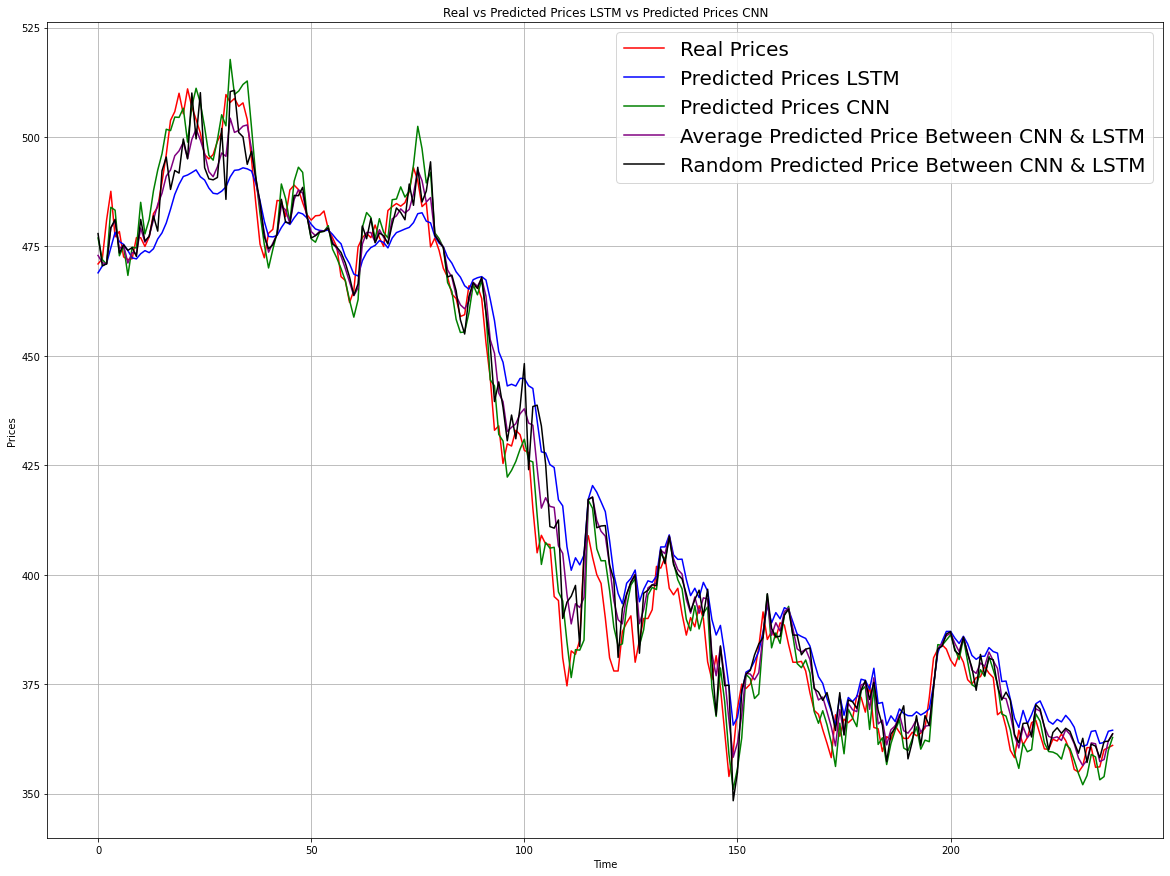

In [ ]:
plt.figure(figsize=(20, 15))

plt.plot(test_open, 'red', label='Real Prices')
plt.plot(predicted_value_lstm, 'blue', label='Predicted Prices LSTM')
plt.plot(predicted_value_cnn, 'green', label='Predicted Prices CNN')
plt.plot(average_prediction, 'purple', label='Average Predicted Price Between CNN & LSTM')
plt.plot(random_average_prediction, 'black', label='Random Predicted Price Between CNN & LSTM')

plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real Price vs Predicted Prices LSTM vs Predicted Prices CNN vs Average Predicted Price Between LSTM & CNN vs Random Predicted Price Between LSTM & CNN [Predicting Price After 30 Days]')

plt.legend(loc='best', fontsize=20)
plt.grid(True)

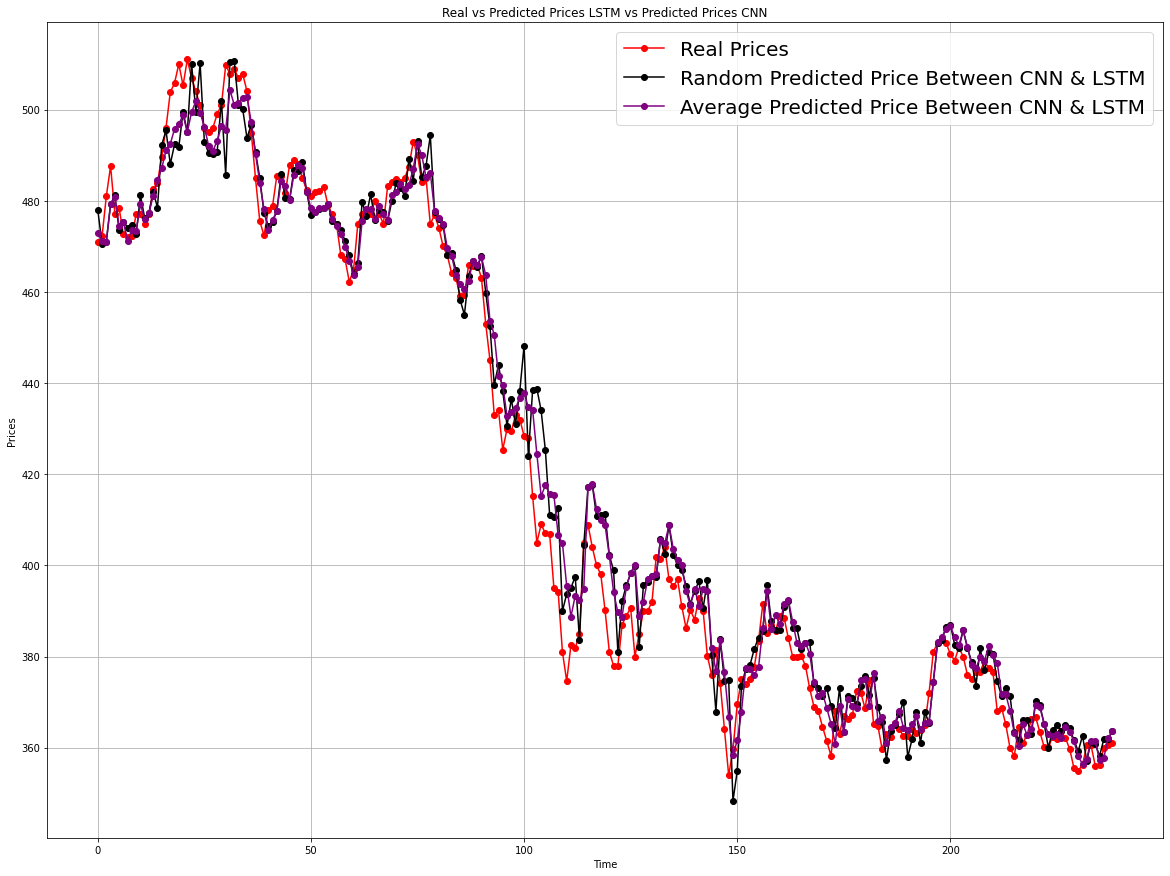

In [ ]:
plt.figure(figsize=(20, 15))

plt.plot(test_open, color='red', marker='o', label='Real Prices')
plt.plot(random_average_prediction, color='black', marker='o', label='Random Predicted Price Between CNN & LSTM')
plt.plot(average_prediction, color='purple', marker='o', label='Average Predicted Price Between CNN & LSTM')

plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real Price vs Average Predicted Price Between LSTM & CNN vs Random Predicted Price Between LSTM & CNN [Predicting Price After 30 Days]')

plt.legend(loc='best', fontsize=20)
plt.grid(True)

In [ ]:
# downloading the data in CSV

pd.DataFrame(average_prediction).to_csv('average_prediction.csv')
pd.DataFrame(predicted_value_lstm).to_csv('predicted_value_lstm.csv')
pd.DataFrame(predicted_value_cnn).to_csv('predicted_value_cnn.csv')
pd.DataFrame(random_average_prediction).to_csv('random_average_prediction.csv')